# 大致流程-tf-idf

- 分词
- 统计全样本词表词频
- 取出停用词
- 使用tf-idf方法表达每个样本
- 使用csr离散矩阵存取tf-idf矩阵

## 使用源数据
本部分所用原始数据取自*preprocessing_exclude_text*部分，*preprocessing_exclude_text*部分最后会输出一份名为**raw_text_data.csv**文件，共三列，分别为id,note_text,标题名。

## tf-idf部分输出

- **seg_sparse_result.npz**：tf-idf离散矩阵，本矩阵默认输出为title2500维+note10000维度，总计12500维，如有不当，可以直接在ipynb文件中 *tf_idf_method.tf_idf_vec()* 函数进行参数的修改。
- **seg_word_list.txt**：tf-idf离散矩阵中每一列对应的词，'t_'标识，说明是title里的词;'n_'标识，说明是note里的词。

In [1]:
import pandas as pd
import pkuseg
from collections import Counter
import ast
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp

# # 分词过程

# raw_text = pd.read_csv('./raw_text_data.csv',encoding='utf-8')#数据读取

# raw_text['note_text'] = raw_text['note_text'].str.replace('\+\-\+','\n')#把+-+分割符改为\n，原本原始数据中的+-+就定义为分段符
# raw_text = raw_text.fillna('')#将NaN填为空字符串，否则后续seg分词会报错

# #分词初始化，领域定位旅游
# seg = pkuseg.pkuseg(model_name='tourism')

# raw_text['note_seg'] = raw_text['note_text'].apply(lambda x: seg.cut(x))#文本分词
# raw_text['title_seg'] = raw_text['标题'].apply(lambda x: seg.cut(x))#标题分词

# raw_text.to_csv('raw_text_data_withseg.csv',index=False,encoding='utf-8')#分词时间较久，所以考虑中途输出一次

In [2]:
#上面代码执行时间较长，故运行一次后中途存出，后面采用如下代码读取进行后续步骤
raw_text = pd.read_csv('./raw_text_data_withseg.csv',encoding='utf-8')
raw_text['note_seg'] = raw_text['note_seg'].map(ast.literal_eval)#字符串转列表
raw_text['title_seg'] = raw_text['title_seg'].map(ast.literal_eval)

In [3]:
raw_text['note_seg'] = raw_text['note_seg'].apply(lambda y: list(filter(lambda x: not x.isdigit(),y)))#去除全数字的词
raw_text['title_seg'] = raw_text['title_seg'].apply(lambda y: list(filter(lambda x: not x.isdigit(),y)))#去除全数字的词


In [4]:
#构建标题大词表
raw_text_title = raw_text['title_seg']
total_words_list_title = []#每个标题所有出现的词
for each_index in raw_text_title.index:
    total_words_list_title.extend(raw_text_title[each_index])
    
#构建游记大词表
raw_text_note = raw_text['note_seg']
total_words_list_note = []#每个游记所有出现的词
for each_index in raw_text_note.index:
    total_words_list_note.extend(raw_text_note[each_index])

In [5]:
#字典化处理
count_note = Counter(total_words_list_note)
count_title = Counter(total_words_list_title)

In [6]:
#导入停用词表
stopwords = []

with open("./stopwords.txt", encoding="utf-8") as f:
    for line in f.readlines():
        line = line.strip('\n')#readlines会读入\n先去掉
        stopwords.append(line)

#通过pprint(count_note.most_common(100))，分别查看note和title出现频率前100的词，将个人认为无用的词语人工筛选出来。
self_check_rm_words = ['-','——','）','（','【','】','#','--','~','#','游记','这里','(',')','[',']','{','}']

#整合最终所要筛除的词，后续添加都可在这一步完成
rm_words = stopwords + self_check_rm_words

In [7]:
#在统计之前将停用词筛除
temp = count_note.copy().keys()#存储一个列表，copy一份是为了是for循环可以跑，里面为所有出现过的词
for each_word in temp:
    if each_word in rm_words:
        count_note.pop(each_word)# 删除要删除的键值对，如{'的':2132197}这个键值对
        
temp = count_title.copy().keys()#存储一个列表，copy一份是为了是for循环可以跑，里面为所有出现过的词
for each_word in temp:
    if each_word in rm_words:
        count_title.pop(each_word)# 删除要删除的键值对，如{'的':2132197}这个键值对

In [13]:
sorted(list(set(count_title.keys())))

['!',
 '"',
 '##',
 '#厦',
 '#夫',
 '#廈',
 '#手',
 '#春',
 '#春季',
 '#梦',
 '#湖',
 '#猴',
 '#行',
 '#逛',
 '#除',
 '&',
 "'",
 '(',
 ')',
 '*',
 '**',
 '***',
 '+',
 '+必',
 '+暴',
 '+束',
 '+玉湖村',
 ',',
 ',半部',
 ',购',
 '---',
 '----',
 '-----',
 '------',
 '-------',
 '--------',
 '----------',
 '----苏',
 '--3',
 '--3万',
 '--5',
 '--50',
 '--七',
 '--三',
 '--三亚',
 '--光',
 '--八',
 '--素可泰',
 '-拉市海',
 '-记',
 '.',
 '..',
 '...',
 '....',
 '.....',
 '......',
 '...To_Sanya',
 '/',
 '0-3',
 '0.6',
 '1%',
 '1.',
 '1.5',
 '1/4',
 '10.21',
 '10.4',
 '1000三',
 '108顿',
 '10万',
 '10号线',
 '10年',
 '10日',
 '10月',
 '10月末',
 '11.11',
 '11号线',
 '11日',
 '11月',
 '12年',
 '12日',
 '12月',
 '13日',
 '1400百',
 '14年',
 '14日',
 '15.25',
 '15日',
 '16日',
 '17日',
 '18,四',
 '18.11.10',
 '18℃',
 '18年',
 '18店',
 '18日',
 '1937.12.13',
 '1k',
 '1万4千',
 '1三亚',
 '1号',
 '1日',
 '1日游',
 '1月',
 '1月份',
 '1青岛',
 '2.23',
 '2.5',
 '20+',
 '20,Go',
 '2000多',
 '2008-2018，十年',
 '200RMB',
 '2010年',
 '2011年',
 '2012世纪',
 '2012年',
 '2013.10.2',
 '201

In [66]:
#此函数可以显示最频繁出现的前100个词demo
pprint(count_title.most_common(100))#输出词频前100的词

[('厦门', 1740),
 ('三亚', 1673),
 ('游', 1625),
 ('上海', 1334),
 ('南京', 1195),
 ('杭州', 894),
 ('旅', 693),
 ('丽江', 648),
 ('攻略', 634),
 ('天', 611),
 ('旅行', 588),
 ('走', 524),
 ('带', 438),
 ('一个', 349),
 ('行', 325),
 ('美食', 294),
 ('三', 271),
 ('两', 257),
 ('江南', 245),
 ('吃', 233),
 ('自由行', 224),
 ('迪士尼', 221),
 ('场', 207),
 ('旅游', 206),
 ('夜', 205),
 ('次', 204),
 ('时光', 202),
 ('1日', 195),
 ('四', 193),
 ('玩', 189),
 ('说', 189),
 ('苏州', 188),
 ('3日', 178),
 ('遇见', 173),
 ('—', 166),
 ('里', 163),
 ('泸沽湖', 160),
 ('周末', 153),
 ('亲子游', 152),
 ('2日', 149),
 ('乌镇', 145),
 ('闺蜜', 143),
 ('美', 142),
 ('魔都', 141),
 ('鼓浪屿', 139),
 ('亲子', 138),
 ('晚', 135),
 ('+', 132),
 ('浪漫', 131),
 ('一日游', 128),
 ('一起', 124),
 ('逛', 124),
 ('金陵', 123),
 ('城市', 122),
 ('4日', 122),
 ('想', 122),
 ('云南', 119),
 ('三日', 118),
 ('千岛湖', 117),
 ('地方', 114),
 ('爱', 112),
 ('梦', 111),
 ('第一', 110),
 ('五', 109),
 ('5日', 109),
 ('西湖', 108),
 ('中', 106),
 ('邂逅', 104),
 ('世界', 103),
 ('自驾', 102),
 ('景点', 99),
 ('篇', 98),
 ('美景', 9

In [67]:
#转series并降序排列
pd_note = pd.Series(count_note)
pd_note = pd_note.sort_values(ascending=False)

pd_title = pd.Series(count_title)
pd_title = pd_title.sort_values(ascending=False)

In [68]:
pd_title[pd_title > 1]#出现频数大于1的词语

厦门    1740
三亚    1673
游     1625
上海    1334
南京    1195
      ... 
共青       2
留住       2
生如       2
订制       2
湖区       2
Length: 3792, dtype: int64

In [69]:
pd_note[pd_note > 1]#出现频数大于1的词语

吃        61588
一个       60394
酒店       52307
三亚       46382
会        44484
         ...  
K8420        2
惺惺           2
出单           2
流脓水          2
杨国福          2
Length: 149181, dtype: int64

In [11]:
class tf_idf_method:
    def __init__(self, data, rm_list):
        '''
            初始化
                data:原始数据，为dataframe
                seg_col_name:分词结果所在列列名，为str
                rm_list:需要忽略的词词典，为list，包含stoplist
        '''
        self.data = data
#         self.seg_col_name = seg_col_name
        self.stop_word = rm_list
#         self.other_x_name = other_x_name  # 非文字特征
#         self.feature_name = other_x_name
#         self.final_X = None  # 最终处理好的X数据

        self.data['note_to_process'] = self.data['note_seg'].apply(lambda x:' '.join(x))#转成字符串，不然不好处理
        self.data['title_to_process'] = self.data['title_seg'].apply(lambda x:' '.join(x))

    
    def tf_idf_vec(self, max_f_title=2500,max_f_note=100000):
        """
            对分词结果进行tf-idf化
            输入：
                max_f = 最大维数,!!!!两个参数可以修改
            输出：
                final_data：最终处理好的数据，title特征在前、note特征在后的sparse matrix
                word_feature_name：每列所代表的词
        """
        word_feature_name = []
        
        #title部分
        corpus_title = self.data['title_to_process']
        vectorizer_title = TfidfVectorizer(stop_words=self.stop_word, max_features=max_f_title) 
        seg_X_title = vectorizer_title.fit_transform(corpus_title)
        
        word_feature_name += [('ttt_' + temp) for temp in vectorizer_title.get_feature_names()]#加入'ttt_'标识，说明是title里的词
        
        #note部分
        corpus_note = self.data['note_to_process']
        vectorizer_note = TfidfVectorizer(stop_words=self.stop_word, max_features=max_f_note) 
        seg_X_note = vectorizer_note.fit_transform(corpus_note)
        
        word_feature_name += [('nnn_' + temp) for temp in vectorizer_note.get_feature_names()]#加入'nnn_'标识，说明是note里的词

        final_data = sp.hstack([seg_X_title, seg_X_note]).tocsr()  # 转为csr矩阵，后期交叉验证，会做行切片
        
        return word_feature_name, final_data

In [12]:
t = tf_idf_method(raw_text,rm_words)
temp_word_list, temp_seg_result = t.tf_idf_vec()

In [13]:
#tf-idf矩阵存取
sp.save_npz('seg_sparse_result.npz',temp_seg_result,True)#压缩存出

#temp_seg_result = sp.load_npz('seg_sparse_result.npz')#数据读入


#tf-idf每列词（特征名）存取
#存
temp_word_list = pd.Series(temp_word_list)
temp_word_list.to_csv('seg_word_list.csv',index=False,encoding='utf-8')
        
# #取
# temp_word_list = pd.read_csv('seg_word_list.csv',encoding='utf-8')
# temp_word_list = temp_word_list.iloc[:,0].tolist()

# 大致流程-word2vec

在tf-idf步骤中，已经有raw_text分好的词，每个文本都有一个list，list中按序存储了词语。

为了在训练word2vec前，去除停用词，拟将list重新连接维str，而后用pd.str方法去除停止词

In [8]:
rm_words4w2v = rm_words.copy()
rm_words4w2v += ['一个','没有']

In [9]:
# #一个例子，删除所有出现过的1
# arr = [1,2,3,4,5,6,1,1,2,3,4]
# print(list(filter(lambda x:x!=1,arr)))

#该部分较久，故考虑中途输出一次
raw_text4w2v = raw_text.copy()#复制一份
raw_text4w2v['title_seg_w2v'] = raw_text4w2v['title_seg'].apply(lambda y: list(filter(lambda x:x not in rm_words4w2v,y)))#去除title中的停用词
raw_text4w2v['note_seg_w2v'] = raw_text4w2v['note_seg'].apply(lambda y: list(filter(lambda x:x not in rm_words4w2v,y)))#去除note中的停用词|
raw_text4w2v.to_csv('raw_text_data_withseg4w2v.csv',index=False,encoding='utf-8')#筛除rm_words4w2v较久，所以考虑中途输出一次


# #上面代码执行时间较长，故运行一次后中途存出，后面采用如下代码读取进行后续步骤
# raw_text4w2v = pd.read_csv('./raw_text_data_withseg4w2v.csv',encoding='utf-8')
# raw_text4w2v = raw_text4w2v[['id','title_seg_w2v','note_seg_w2v']]
# raw_text4w2v['title_seg_w2v'] = raw_text4w2v['title_seg_w2v'].map(ast.literal_eval)#字符串转列表
# raw_text4w2v['note_seg_w2v'] = raw_text4w2v['note_seg_w2v'].map(ast.literal_eval)

In [10]:
import gzip
import gensim
import logging
 
#logging格式设置
logging.basicConfig(format="", level=logging.INFO)

In [11]:
title_sentences = raw_text4w2v['title_seg_w2v'].tolist()
title4w2v_model = gensim.models.Word2Vec(title_sentences, min_count=2,vector_size=32,epochs=20)

note_sentences = raw_text4w2v['note_seg_w2v'].tolist()
note4w2v_model = gensim.models.Word2Vec(note_sentences, min_count=2,vector_size=128,epochs=20)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
PROGRESS: at sentence #10000, processed 56065 words, keeping 10282 word types
collected 10384 word types from a corpus of 57121 raw words and 10196 sentences
Creating a fresh vocabulary
Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 3786 unique words (36.45993836671803%% of original 10384, drops 6598)', 'datetime': '2021-12-19T22:10:24.472383', 'gensim': '4.1.2', 'python': '3.6.13 (default, Sep 23 2021, 07:38:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
Word2Vec lifecycle event {'msg': 'effective_min_count=2 leaves 50523 word corpus (88.44908177377847%% of original 57121, drops 6598)', 'datetime': '2021-12-19T22:10:24.476367', 'gensim': '4.1.2', 'python': '3.6.13 (default, Sep 23 2021, 07:38:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
deleting the raw coun

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
PROGRESS: at sentence #10000, processed 9820713 words, keeping 330768 word types
collected 332467 word types from a corpus of 9919645 raw words and 10196 sentences
Creating a fresh vocabulary
Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 149173 unique words (44.86851326597828%% of original 332467, drops 183294)', 'datetime': '2021-12-19T22:10:30.075086', 'gensim': '4.1.2', 'python': '3.6.13 (default, Sep 23 2021, 07:38:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
Word2Vec lifecycle event {'msg': 'effective_min_count=2 leaves 9736351 word corpus (98.15221210033222%% of original 9919645, drops 183294)', 'datetime': '2021-12-19T22:10:30.076071', 'gensim': '4.1.2', 'python': '3.6.13 (default, Sep 23 2021, 07:38:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
dele

EPOCH 5 - PROGRESS: at 84.98% examples, 729065 words/s, in_qsize 5, out_qsize 0
EPOCH 5 - PROGRESS: at 91.52% examples, 729123 words/s, in_qsize 5, out_qsize 0
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 5 : training on 9919645 raw words (9508101 effective words) took 13.0s, 728937 effective words/s
EPOCH 6 - PROGRESS: at 9.33% examples, 719120 words/s, in_qsize 5, out_qsize 0
EPOCH 6 - PROGRESS: at 16.72% examples, 725032 words/s, in_qsize 5, out_qsize 0
EPOCH 6 - PROGRESS: at 25.13% examples, 725228 words/s, in_qsize 5, out_qsize 0
EPOCH 6 - PROGRESS: at 33.47% examples, 721761 words/s, in_qsize 6, out_qsize 0
EPOCH 6 - PROGRESS: at 42.14% examples, 716950 words/s, in_qsize 5, out_qsize 0
EPOCH 6 - PROGRESS: at 53.05% examples, 716979 words/s, in_qsize 5, out_qsize 0
EPOCH 6 - PROGRESS: at 61.57% examples, 719564 words/s, in_qsize 5, out_qsize 0
EP

EPOCH 12 - PROGRESS: at 9.12% examples, 703230 words/s, in_qsize 5, out_qsize 0
EPOCH 12 - PROGRESS: at 16.72% examples, 721306 words/s, in_qsize 5, out_qsize 0
EPOCH 12 - PROGRESS: at 25.36% examples, 726118 words/s, in_qsize 5, out_qsize 0
EPOCH 12 - PROGRESS: at 33.67% examples, 725133 words/s, in_qsize 5, out_qsize 0
EPOCH 12 - PROGRESS: at 42.39% examples, 725917 words/s, in_qsize 6, out_qsize 0
EPOCH 12 - PROGRESS: at 53.40% examples, 725157 words/s, in_qsize 5, out_qsize 0
EPOCH 12 - PROGRESS: at 62.12% examples, 725121 words/s, in_qsize 5, out_qsize 0
EPOCH 12 - PROGRESS: at 72.20% examples, 725099 words/s, in_qsize 5, out_qsize 0
EPOCH 12 - PROGRESS: at 75.17% examples, 726799 words/s, in_qsize 5, out_qsize 0
EPOCH 12 - PROGRESS: at 79.24% examples, 726590 words/s, in_qsize 5, out_qsize 0
EPOCH 12 - PROGRESS: at 84.74% examples, 727460 words/s, in_qsize 5, out_qsize 0
EPOCH 12 - PROGRESS: at 91.40% examples, 727543 words/s, in_qsize 5, out_qsize 0
worker thread finished; await

EPOCH 18 - PROGRESS: at 53.26% examples, 721320 words/s, in_qsize 5, out_qsize 0
EPOCH 18 - PROGRESS: at 61.98% examples, 722878 words/s, in_qsize 6, out_qsize 0
EPOCH 18 - PROGRESS: at 72.20% examples, 723866 words/s, in_qsize 5, out_qsize 0
EPOCH 18 - PROGRESS: at 75.17% examples, 725482 words/s, in_qsize 6, out_qsize 0
EPOCH 18 - PROGRESS: at 79.24% examples, 726302 words/s, in_qsize 5, out_qsize 0
EPOCH 18 - PROGRESS: at 84.58% examples, 725942 words/s, in_qsize 6, out_qsize 1
EPOCH 18 - PROGRESS: at 91.40% examples, 727215 words/s, in_qsize 5, out_qsize 0
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 18 : training on 9919645 raw words (9508591 effective words) took 13.1s, 727880 effective words/s
EPOCH 19 - PROGRESS: at 9.55% examples, 727094 words/s, in_qsize 5, out_qsize 0
EPOCH 19 - PROGRESS: at 16.54% examples, 706398 words/s, in_qsize 5, out_

In [12]:

title4w2v_model.save('./title4w2v')   #保存

note4w2v_model.save('./note4w2v')

#model = Word2Vec.load('word2vec')   #加载model

Word2Vec lifecycle event {'fname_or_handle': './title4w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-12-19T22:16:06.224427', 'gensim': '4.1.2', 'python': '3.6.13 (default, Sep 23 2021, 07:38:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'saving'}
not storing attribute cum_table
saved ./title4w2v
Word2Vec lifecycle event {'fname_or_handle': './note4w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-12-19T22:16:06.268633', 'gensim': '4.1.2', 'python': '3.6.13 (default, Sep 23 2021, 07:38:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'saving'}
storing np array 'vectors' to ./note4w2v.wv.vectors.npy
storing np array 'syn1neg' to ./note4w2v.syn1neg.npy
not storing attribute cum_table
saved ./note4w2v


In [17]:
title4w2v_model.wv.

TypeError: get_vector() missing 1 required positional argument: 'key'

In [64]:
title_model.wv['古都']

array([-0.24591494, -0.37228143,  0.22792809,  0.31948858,  0.09574063,
       -0.396393  ,  0.63277954,  0.08666699, -0.33022806, -0.09776949,
        0.4139562 , -0.35060456, -0.12369115, -0.03222762,  0.05917019,
        0.07834374, -0.2018643 ,  0.0534095 ,  0.10587415,  0.07067019,
        0.6824205 ,  0.68287736,  0.60660183, -0.25658116,  0.25118315,
        0.05953793, -0.49816465,  0.06500566, -0.13022274, -0.36957818,
        0.11386707,  0.01490659], dtype=float32)

In [ ]:
note4w2v_model.wv.most_similar('一个',topn=20)

# 词云图

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from scipy.ndimage import gaussian_gradient_magnitude

In [16]:
title_total_corpus = ''

for i in [' '.join(each_c) for each_c in raw_text['title_seg'].tolist()]:
    title_total_corpus += ' '
    title_total_corpus += i

    
note_total_corpus = ''

for i in [' '.join(each_c) for each_c in raw_text['note_seg'].tolist()]:
    note_total_corpus += ' '
    note_total_corpus += i

In [24]:
rm_words4cloud = rm_words.copy()#在绘制词云前需要删除的词语，可通过手动添加
rm_words4cloud += ['一个','没有','地方','很多','其实','会']

(-0.5, 20084.5, 16184.5, -0.5)

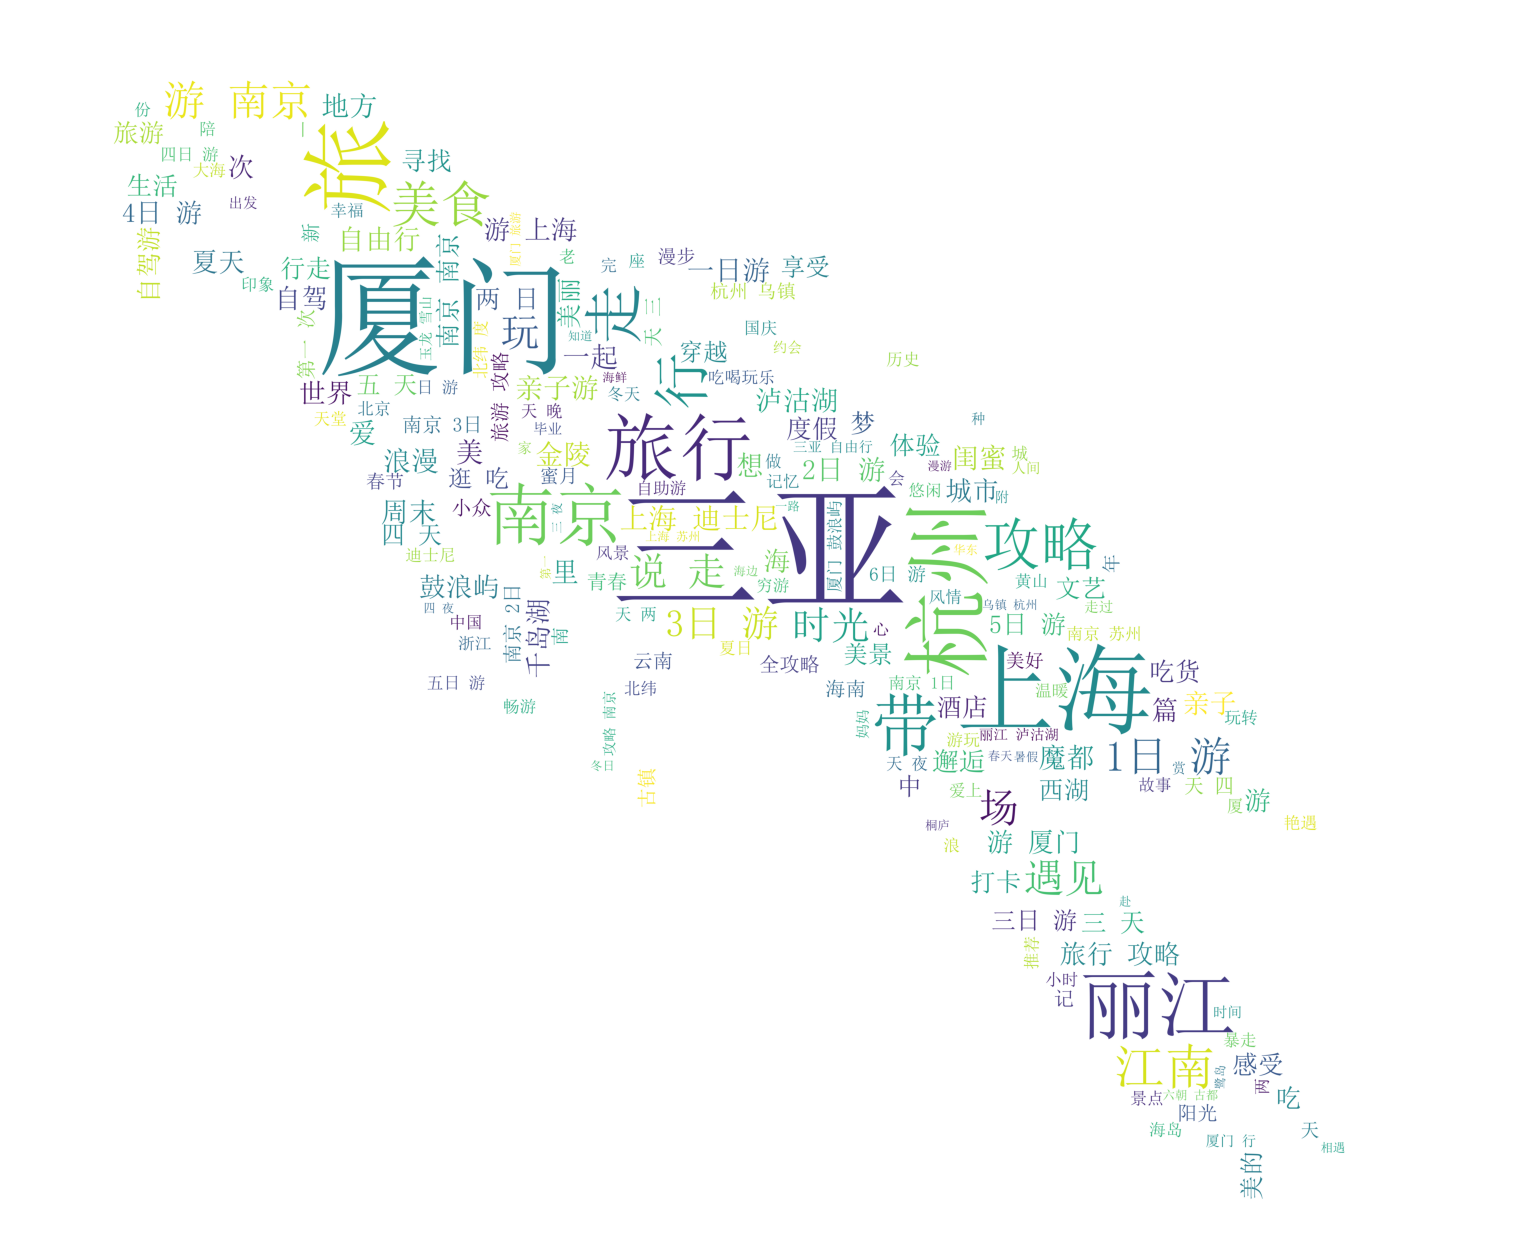

In [27]:
#标题词云图
# Mask image
mask_color = np.array(Image.open('./parrot-by-jose-mari-gimenez2.jpg'))

mask_color = mask_color[::3, ::3]
mask_image = mask_color.copy()
mask_image[mask_image.sum(axis=2) == 0] = 255

# Edge detection
edges = np.mean([gaussian_gradient_magnitude(mask_color[:, :, i]/255., 2) for i in range(3)], axis=0)
mask_image[edges > .08] = 255

word_cloud = WordCloud(font_path="simsun.ttc",  # 设置词云字体
                       background_color="white", # 词云图的背景颜色
                       stopwords=rm_words4w2v,# 去掉的停词
                      width=800, height=400,
                      scale=15,
                      mask=mask_image)

word_cloud.generate(title_total_corpus)

# 运用matplotlib展现结果
plt.subplots(figsize=(12,8),dpi=200)
plt.imshow(word_cloud)
plt.axis("off")

(-0.5, 18449.5, 13274.5, -0.5)

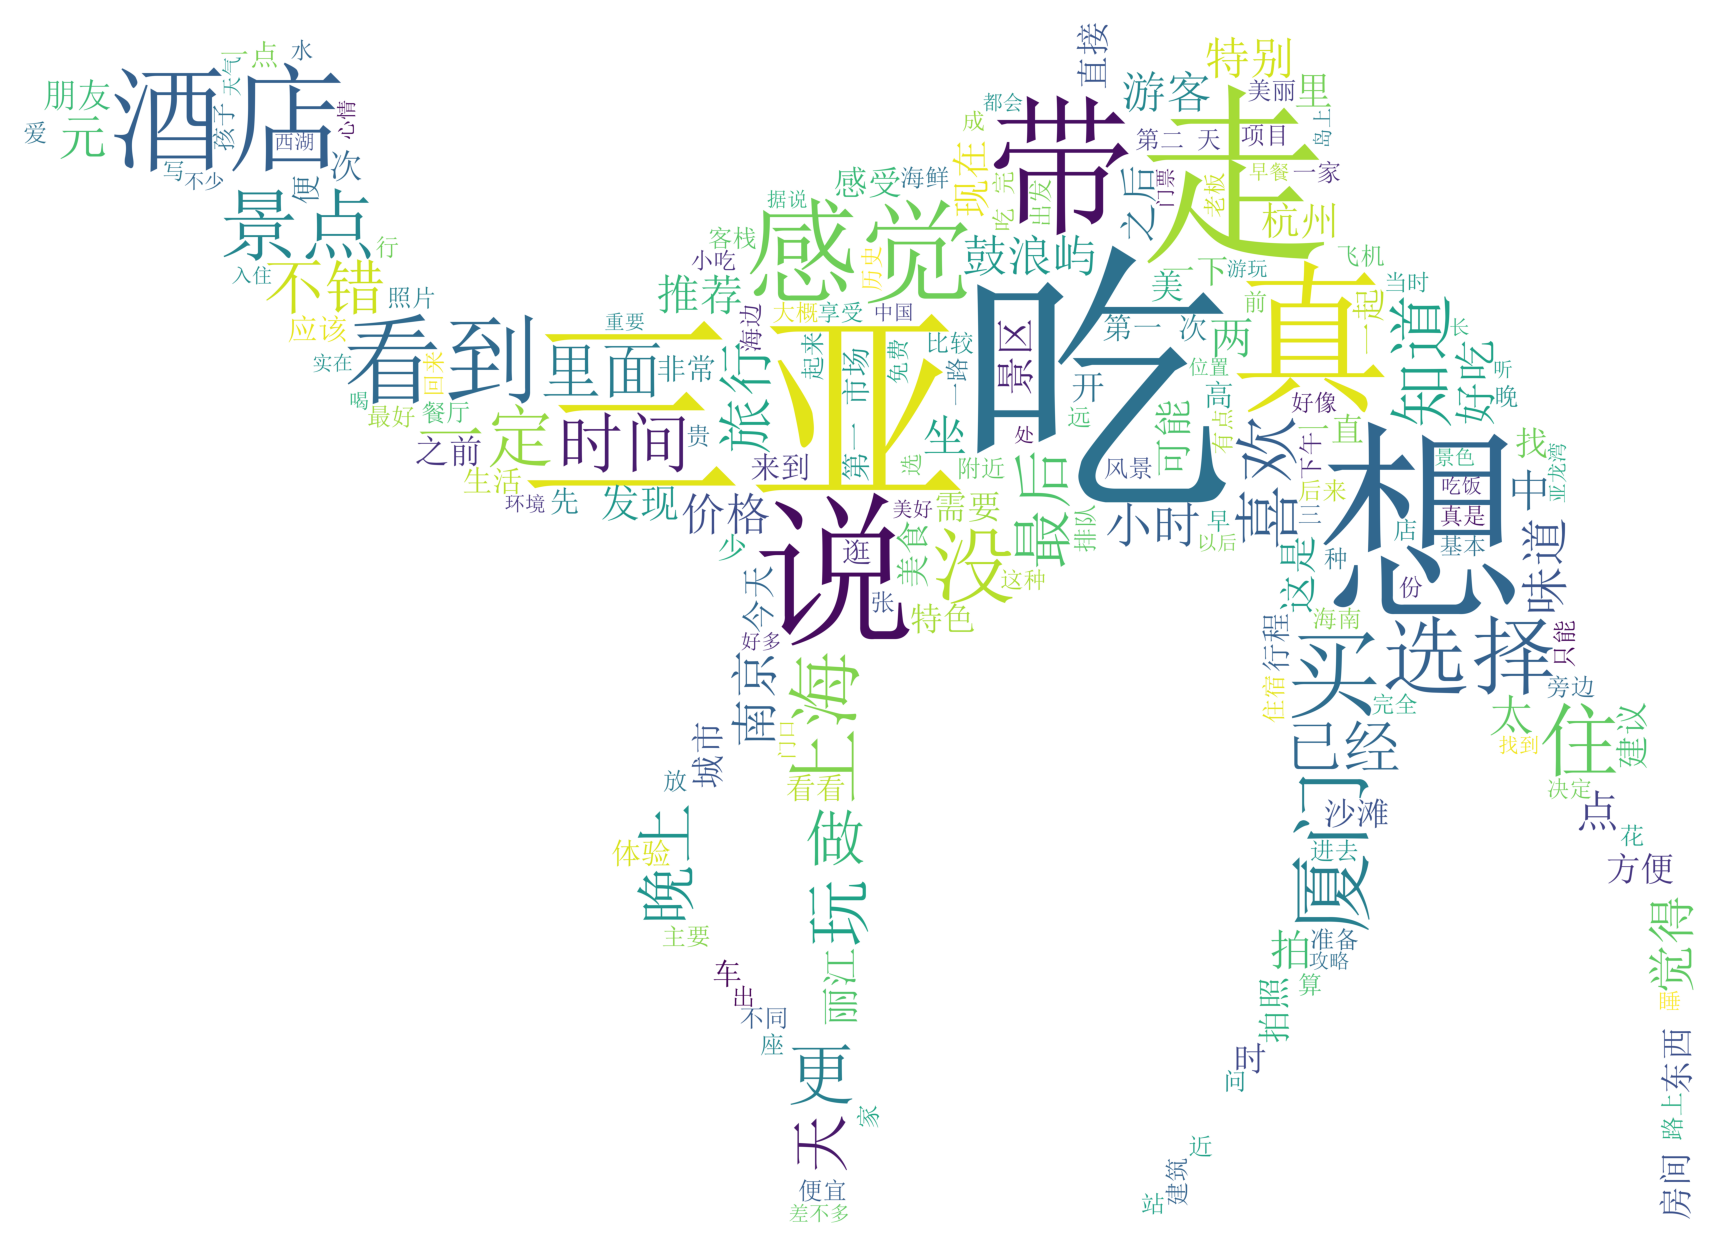

In [25]:
#游记文本词云图
# Mask image使用qunar图标
mask_color = np.array(Image.open('./qunar.jpg'))
mask_color = mask_color[:,:,:3]
#mask_color = 255-mask_color

flag = 220#设置一个阈值，将底图化为黑白部分。
mask_color[mask_color>flag] = 255
mask_color[mask_color<=flag] = 0


word_cloud = WordCloud(font_path="simsun.ttc",  # 设置词云字体
                       background_color="white", # 词云图的背景颜色
                       stopwords=rm_words4cloud,# 去掉的停词
                      width=800, height=400,
                      scale=15,
                      mask=mask_color)

word_cloud.generate(note_total_corpus)

# 运用matplotlib展现结果
plt.subplots(figsize=(12,8),dpi=200)
plt.imshow(word_cloud)
plt.axis("off")